# Model Diagnostic Checking
*R.A. Collenteur, University of Graz, July 2020*.

This notebook provides an overview of the different methods that are available for diagnostic checking of the models residuals in Pastas. Readers who want to get a quick overview of how to perform diagnostic checks on Pastas models are referred to section 2, while sections 3 to 6 are recommended for readers looking for in-depth discussions of the individual methods.

1. [Introduction](#Introduction)
5. [Diagnostic Checking in Pastas in Practice](#Diagnostics-checking-in-practice)
2. [Checking for autocorrelation](#Checking-for-autocorrelation)
3. [Checking for Homoscedasticity](#Checking-for-homoscedasticity)
4. [Checking for Normality](#Checking-for-Normal-distribution)
6. [References](#References)

## Introduction
Diagnostic checking is a common step in the time series modelling proces, subjecting a calibrated model to various statistical tests to ensure that the model adequately describes the observed time series [(Hipel & McLeod, 2005)](#References). Diagnostics checks are performed on the residual or noise series of a model, depending on whether or not a noisemodel was applied in the modelling process. We will refer to the series that was minimized during parameter estimation as the "residuals". In practice in Pastas models, these can come from `ml.noise()` or `ml.residuals()`. Regardless of this, the diagnostics tests that may be performed remain the same.

### Why to check: reasons to diagnose
Before we start the discussion of what to check, let's briefly discuss why we would want to perform diagnostic checks at all. In general, diagnostic checks should be performed when you want to make inferences with a model, in particular when the estimated standard errors of the parameters are used to make such inferences. For example, if you want to draw the confidence interval of the estimated step response for a variable, you will use the standard errors of the parameters to do so. This assumes that the standard errors are estimated accurately, which may assumed if the minimized residual series agree with a number of assumptions on the characteristics of the model residuals.

<div class="alert alert-block alert-info admonition-tip">
<b>Rule-of-thumb:</b> when the standard errors of the parameters are used, the model residuals should be diagnostically checked.
</div>

### What to check: assumptions of white noise
The methods used for the estimation of these standard errors assume that the model residuals behave as white noise with a mean of zero and noise values that are independent from each other (i.e., no significant autocorrelation). Additionally, it is often assumed that the residuals are homoscedastic (i.e., have a constant variance) and follow a normal distribution. The first two assumptions are the most important, having the largest impact on the estimated standard errors of the parameters [(Hipel & McLeod, 2005)](#References). Additionally to these four assumptions, the model residuals should be uncorrelated with any of the input time series. If the residuals are found to behave as white noise, we may assume that the standard errors of the parameters have been accurately estimated and we may use them for inferential analyses.

### How to check: visualisation & hypothesis testing
The assumptions outlined above may be checked through different types of visualisation and hypothesis testing of the model residuals. For the latter, statistical tests are used to test the hypothesis that the residuals are e.g., independent, homoscedastic, or normally distributed. These tests typically test a hypothesis with some version of the following Null hypothesis ($H_0$) and the Alternative hypothesis ($H_A$):

- $H_0$: The residuals are independent, homoscedastic, or normally distributed
- $H_A$: The residuals are not independent, homoscedastic, or normally distributed

All hypothesis tests compute a certain test statistic (e.g., $Q_{test}$), which is compared to a theoretical value according to a certain distribution (e.g., $\chi^2_{\alpha, h}$) that depends on the level of significance (e.g., $\alpha=0.05$) and sometimes the degrees of freedom $h$. The result of a hypothesis test either rejects the Null hypothesis or fails to reject the Null hypothesis, but can never be used to accept the Alternative hypothesis. For example, if an hypothesis test for autocorrelation fails to reject the hypothesis we may conclude that there is no significant autocorrelation in the residuals, but cannot conclude that there is no autocorrelation. 

In [1]:
import numpy as np
import pandas as pd
import pastas as ps
from scipy import stats

import matplotlib.pyplot as plt
ps.set_log_level("ERROR")
ps.show_versions(numba=True)

Python version: 3.7.6 | packaged by conda-forge | (default, Jun  1 2020, 18:33:30) 
[Clang 9.0.1 ]
Numpy version: 1.18.5
Scipy version: 1.4.0
Pandas version: 1.0.5
Pastas version: 0.15.0b
numba version:  0.49.1


## Create and calibrate a pastas Model
To illustrate how to perform diagnostic checking of a Pastas model, a simple model using precipitation and evaporation to simulate the groundwater levels is created. The model is calibrated using a noisemodel with one parameter. Finally, a plot is created using `ml.plots.results()` that shows the simulated groundwater levels, the model residuals and noise and the calibrated parameters values and their estimated standard errors. 

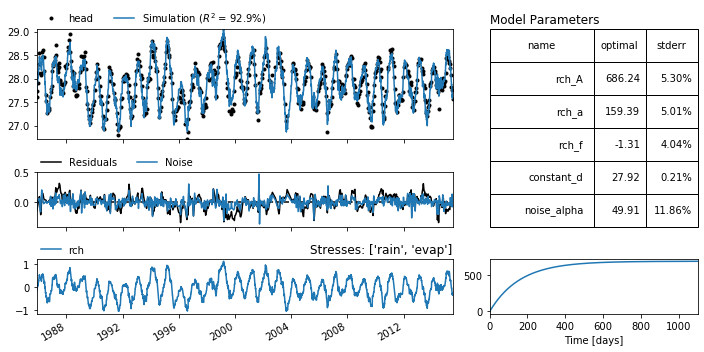

In [2]:
# Import groundwater, rainfall and evaporation time series
head = pd.read_csv('../data/head_nb1.csv', parse_dates=['date'], index_col='date', squeeze=True)
rain = pd.read_csv('../data/rain_nb1.csv', parse_dates=['date'], index_col='date', squeeze=True)
evap = pd.read_csv('../data/evap_nb1.csv', parse_dates=['date'], index_col='date', squeeze=True)

ml = ps.Model(head)
sm = ps.RechargeModel(rain, evap, rfunc=ps.Exponential, name="rch")
ml.add_stressmodel(sm)
ml.solve(report=False)
axes = ml.plots.results(figsize=(10,5))

## Diagnostics checking of Pastas models
Let's say we want to plot the 95% confidence intervals of the simulated groundwater levels that results from uncertainties in the calibrated parameters. Such an analysis would clearly use the standard errors of the parameters, and before we proceed to compute any confidence intervals we should check if the modeled noise agrees with the assumptions of white noise. A noise model was used during calibrations and therefore the noise returned by the `ml.noise()` method should be tested on these assumptions.

### ml.plots.diagnostics
To quicky diagnose the noise series on the different assumptions of white noise, the noise series may be visualized using the `ml.plots.diagnostics()` method. This method visualizes the noise series in different ways to test the different assumptions. The method will internally check if a noise model was used during parameter calibration, and select the appropriate residuals series from `ml.residuals()` or `ml.noise()`.

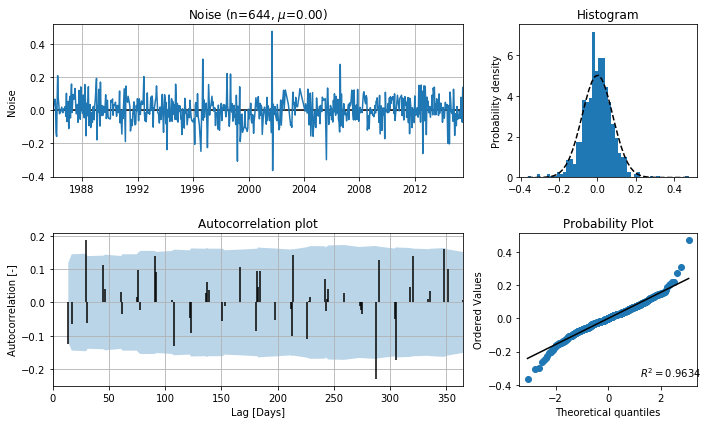

In [3]:
alpha = 0.05

ml.plots.diagnostics();

The top-left plot shows the noise time series, which should look more or less random without a clear (seasonal) trend. The title of this plot also includes the number of observations $n$ and the mean value of the modeled noise $\mu$, which should be around zero. The bottom-left plot shows the autocorrelations for lags up to one year and the 95% confidence interval. Approximately 95% of the autocorrelation values should fall between these boundaries. The upper-right plot shows a histogram of the noise series along with a normal distribution fitted to the data. This plot may be used to assess how well the noise series resemble a normal distribution. The bottom-right plot may also be used to assess the normality of the noise series, using a probability plot of the data.

### ml.stats.diagnostics
The visual interpretation of the noise series is (clearly) subjective, but still provides a powerfull tool to test the noise series and quickly identify any violations of the assumption of white nose. For a more objective evaluation of the model assumptions, hypothesis tests may be used. To perform multiple hypothesis tests on the noise series at once, Pastas provides the `ml.stats.diagnostics()` method as follows.

In [4]:
ml.stats.diagnostics(alpha=0.05)

,Checks,Statistic,P-value,Reject H0
Shapiroo,Normality,0.97,0.00,True
D'Agostino,Normality,56.49,0.00,True
Runs test,Autocorr.,0.64,0.52,False
Stoffer-Toloi,Autocorr.,238.37,1.00,False


The `ml.stats.diagnostics` method returns a Pandas DataFrame with an overview of the results of the different hypothesis tests. The first column ("Checks") reports what assumption is tested by a certain test and the second column ("Statistic") reports the test statistic that is computed for that test. The probability of each test statistic is reported in the third column ("P-value") and the fourth column ("Reject H0") reports the result of the hypothesis test. Recall that the Null-hypotheses assume that the data resembles white noise. This means that if $H_0$ is rejected (or `Reject H0 = True`), that test concludes that the data does not agree with one of the assumptions of white noise. The following table provides an overview of the different hypothesis tests that are reported by `ml.stats.diagnostics()`.


| Name | Checks | Pastas/Scipy method | Description | Non-equidistant |
|:-----|:-----|:--------------|:-----------------------------------------|----------------:|
| shapiro-wilk | Normality | `scipy.stats.shapiro`| The Shapiro-Wilk test tests the null hypothesis that the data was drawn from a normal distribution. | Unknown |
| D'Agostino |  Normality | `scipy.stats.normaltest`| This test checks if the noise series comes from a normal distribution (H0 hypothesis). | Unknown |
| Ljung-Box test| Autocorrelation | `ps.stats.ljung_box`| This test checks whether the autocorrelations of a time series are significantly different from zero.| No |
| Durbin Watson test | Autocorrelation | `ps.stats.durbin_watson` | This tests diagnoses for autocorrelation at a lag of one time step. | No |
| Stoffer-Toloi test | Autocorrelation | `ps.stats.stoffer_toloi`| This test is similar to the Ljung-Box test, but is adapted for missing values | Yes |
| Runs test | Autocorrelation | `ps.stats.runs_test` | This test checks whether the values of a time series are random without assuming any probability distribution. | Yes |

Some of the test are known to be appropriate to test time series with non-equidistant time steps while others are not. The method `ml.stats.diagnostics()` will check use different test depending on the existence of non-equidistant time steps or not. All methods are also available as separate methods and may also be used to test time series that are not obtained from a Pastas model.

## A closer look at the hypothesis tests
While the results of `ml.stats.diagnostics` may look straightforward, the interpretation is unfortunately not because the results are highly dependent on the input data. To correctly interpret the hypothesis tests it is particularly important to know whether or not the noise time series have equidistant time steps and how many observations the time series contains. For example, some of the tests are only valid when used on equidistant time series. Other tests are sensitive to too few observation (e.g., ljung-box) or too many observations (e.g., Shapiroo-Wilk). In the following sections each of these hypothesis tests is discussed in more detail. To show the functioning of the different hypothesis tests a synthetic time series is created by randomly drawing values from a normal distribution.

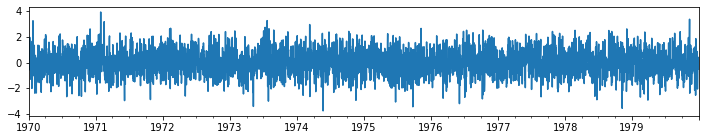

In [5]:
random_seed = np.random.RandomState(12345)
index = pd.to_datetime( np.arange(3650), unit="D")
noise = pd.Series(random_seed.normal(0, 1, len(index)), index=index)
noise.plot(figsize=(12,2))

## Checking for autocorrelation
The first thing we check is if the values of residual series are independent form each other, or in other words, are not correlated. The correlation of a time series with a lagged version of itself is also referred to as autocorrelation, and we often say that we want to check that there is no significant autocorrelation in the residual time series. The following methods to test for autocorrelation are available in Pastas:

| Name | Pastas method | Description | Non-equidistant |
|:-----|:--------------|:-----------------------------------------|----------------:|
| Visualisation | `ps.stats.plot_acf` | Visualisation of the autocorrelation and its confidence intervals. | Yes |
| Ljung-Box test| `ps.stats.ljung_box`| This test checks whether the autocorrelations of a time series are significantly different from zero.| No |
| Durbin Watson test | `ps.stats.durbin_watson` | This tests diagnoses for autocorrelation at a lag of one time step. | No |
| Stoffer-Toloi test |`ps.stats.stoffer_toloi`| This test is similar to the Ljung-Box test, but is adapted for missing values | Yes |
| Runs test |`ps.stats.runs_test` | This test checks whether the values of a time series are random without assuming any probability distribution. | Yes |

Whereas many time series models have equidistant time steps, the residuals of Pastas models may have non-equidistant time steps. To deal with this property, functions have been implemented in Pastas that can deal with non-equidistant time steps [(Rehfeld et al., 2011)](#References). We therefore recommend to use the statistical methods supplied in Pastas, unless the modeller is sure he/she is dealing with equidistant time steps. See the additional Notebook on the autocorrelation function for more details and a proof of concept.

### Visual interpretation of the autocorrelation
To diagnose the model residuals for autocorrelation we first plot the autocorrelation function (ACF) using the `ps.stats.plot_acf` method and perform a visual interpretation of the models residuals. The created plot shows the autocorrelation function up to a time lag of 250 days. The blue-shaded area denotes the 95\% confidence interval (1-$\alpha$). If 95\% of the autocorrelations fall within this confidence interval (that is, 0.95 $\cdot$ 250 = ±237 of them), we may conclude that there is no significant autocorrelation in the residuals. 

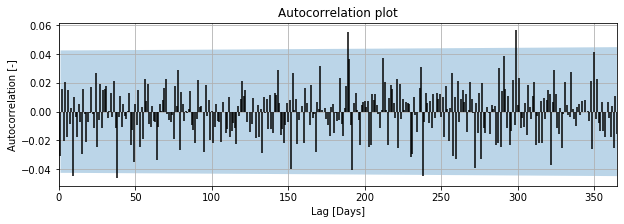

In [6]:
ax = ps.stats.plot_acf(noise, acf_options=dict(bin_width=0.5), figsize=(10,3), alpha=0.01)

The number of time lags to control for autocorrelation has to be chosen by the modeler, for example based on the knowledge of hydrological processes. For example, evaporation shows a clear yearly cycle and we may expect autocorrelation at lags of one year as a result of this. We therefore recommend to test for autocorrelation for all lags up to a lag of $k_{max}=365$ days here. It is noted here the number of lags $k$ [-] to calculate the autocorrelation for may depend on the time step of the residuals ($\Delta t$). For example, if daily residuals are available ($\Delta t = 1$ day), the autocorrelation has to be computed for $k=365$ [-] lags.

### The Ljung-Box test for autocorrelation
The Ljung-Box test [(1978)](#References) tests the null-hypothesis that the residual series are independently distributed up to a desired time lag $k$ and is computed as follows:

$$Q_k = n(n+2) \sum_{k=1}^{h} \frac{\rho_k^2}{n-k} $$

where $\rho_k$ is the autocorrelation at lag $k$, $h$ is the maximum lag used for calculation, and $n$ is the number of values in the noise series. The computed $Q$-statistic is then compared to a critical value computed from a $\chi^2_{\alpha, h-p}$ distribution with a significance level $\alpha$ and $h-p$ degrees of freedom, where $h$ is the number of lags and $p$ the number of calibrated model parameters.

In [7]:
stat, p = ps.stats.ljung_box(noise, lags=365)

if p > alpha:
    print("Failed to reject the Null-hypothesis, no significant autocorrelation. p =", p.round(2))
else:
    print("Reject the Null-hypothesis. p =", p.round(2))

Failed to reject the Null-hypothesis, no significant autocorrelation. p = 0.38


**Considerations for this test:** 

- The time series should have equidistant time steps. An adapted version of the Ljung-Box test is available and explained below (Stoffer and Toloi)
- A potential problem of the Ljung-Box test is the low power of the test when testing for a large number of lags using a small sample size $n$. It has been suggested that suggested that $k \leq n/4$ but also as low as $k \leq n/20$. If we are using daily groundwater levels observations, and we want to test for autocorrelation for lags up to one year (365 days) this means that we need between 4 and ten years of data. 


### The Durbin-Watson Test
The Durbin-Watson statistic [(1951)](#References) tests the null-hypothesis that the correlation between the noise values at lag one equals zero and is computed as follows:  

$$ DW = \frac{\sum_{t=2}^{n}(\upsilon_t-\upsilon_{t-1}^2)}{\sum_{t=1}^{n}\upsilon_t^2} $$

where $n$ is the number of values in the noise series. The test-statistic has a range $0 \geq DW \leq 4$, where values of $DW < 2$ indicate a positive correlation and values of $DW > 2$ indicates negative autocorrelation. The Durbin-Watson test requires a constant time interval of the noise series and tests for autocorrelation at a lag of 1 time step.

In [8]:
stat, p = ps.stats.durbin_watson(noise)

print(stat)

2.06172929207982


**Considerations for this test:** 

- The time series should have equidistant time steps
- The Durbin-Watson test tests for autocorrelation at lag 1 but not for larger time lags.
- The test statistic for this test is difficult to compute and is usually obtained from pre-calculated tables.

### The Stoffer-Toloi test
Stoffer and Toloi [(1992)](#References) extended the Ljung-Box test to also work with missing data. The test statistic is computed as follows:

$$Q_k = n^2 \sum_{k=1}^{h} \frac{\hat{\rho}_k^2}{n-k} $$

where $\hat{\rho}_k$ is the autocorrelation for lag $k$. When the residual time series have non-equidistant time steps it is recommended to use this test over the original Ljung-Box test.

In [9]:
stat, p = ps.stats.stoffer_toloi(noise, lags=365, freq="D")

if p > alpha:
    print("Failed to reject the Null-hypothesis, no significant autocorrelation. p =", p.round(2))
else:
    print("Reject the Null-hypothesis")

Failed to reject the Null-hypothesis, no significant autocorrelation. p = 0.88


The Stoffer-Toloi test is strictly an adapted version of the Ljung-Box test to deal with missing data in a time series and not a time series with non-equidistant time steps. This means that the time series is updated to an equidistant time series by filling nan-values. 

**Considerations for this test:** 

- Test is also applicable to irregular time series
- The time step has to be chosen (e.g., Days). This should not be smaller than the smallest time step or the test will most likely fail to reject $H_0$ anyway.

### The Runs test
Wald and Wolfowitz developed [(1943)](#References) developed a distribution free test (i.e., no normal distribution is assumed) to test for autocorrelation. This test is also appropriate for non-equidistant time steps in the residuals time series. The Null-hypothesis is that the residual time series is a random sequence of positive and negative values. The alternative hypothesis is that they are non-random. The test statistic is compuated as follows:

$$ Z = \frac{R-\bar{R}}{\sigma_R}$$

where $R$ is the number of runs, $\bar{R}$ the expected number of runs and $\sigma_R$ the standard deviation of the number of runs. A run is defined as the number of sequences of exclusively postitive and negative values in the time series. 

In [10]:
stat, p = ps.stats.runs_test(noise)

if p > alpha:
    print("Failed to reject the Null-hypothesis, no significant autocorrelation. p =", p.round(2))
else:
    print("Reject the Null-hypothesis")

Failed to reject the Null-hypothesis, no significant autocorrelation. p = 0.13


**Considerations for this test:** 

- Test is also applicable to time series with non-equidistant time steps.

## Checking for Normality
A common assumption is that the residuals follow a Normal distribution, although in principle it is also possible that the residuals come from another distribtion. Testing whether or not a time series may come from a normal distribution is notoriously difficult, especially for larger sample size (e.g., more groundwater level observations). It may therefore not always be easy to objectively determine whether or not the residuals follow a normal distribution. An good initial method to assess the normality of the residuals is to plot a histogram of the residuals and compare that to the theoretical normal distribution, along with a probability plot. The following methods may be used to check the normality of the residual series:


| Name | Scipy method | Description | Non-equidistant Time series |
|:-----|:--------------|:------------|----------------:|
| Histogram plot | `numpy.histogram` | Plot a histogram of the residuals time series and compare to a normal distribution. | Unknown |
| Probability plot | `scipy.stats.probplot`| Plot a histogram of the residuals time series and compare to a normal distribution. | Unknown |
| shapiro-wilk |`scipy.stats.shapiro`| The Shapiro-Wilk test tests the null hypothesis that the data was drawn from a normal distribution. | Unknown |
| D'Agostino |`scipy.stats.normaltest`| This test checks if the noise series comes from a normal distribution (H0 hypothesis). | Unknown |

Shapiro and Wilk [(1965)](#References) developed a test to test if a time series may come from a normal distribution. Implemented in Scipy as `scipy.stats.shapiro`.

In [11]:
stat, p = stats.shapiro(noise)

if p > alpha:
    print("Failed to reject the Null-hypothesis, residuals may come from Normal distribution. p =", np.round(p, 2))
else:
    print("Reject the Null-hypothesisp =", np.round(p, 2))

Failed to reject the Null-hypothesis, residuals may come from Normal distribution. p = 0.59


D'Agostino and Pearson [(1973)](#References) developed a test to detect non-normality of a time series. This test is implemented in Scipy as `scipy.stats.normaltest`.

In [12]:
stat, p = stats.normaltest(noise)

if p > alpha:
    print("Failed to reject the Null-hypothesis, residuals may come from Normal distribution. p =", p.round(2))
else:
    print("Reject the Null-hypothesis. p =", p.round(2))

Failed to reject the Null-hypothesis, residuals may come from Normal distribution. p = 0.99


As the p-value is larger than $\alpha=0.05$ it is possible that the noise series comes from a normal distribution, so the Null hypothesis (series comes from a normal distribution) is not rejected.

## Checking for homoscedasticity
The second assumption we check is if the residuals are so-called homoscedastic, which means that the values of the residuals are independent of the observed groundwater levels. 
The following tests for homoscedasticity are available:

| Name | Pastas method | Description | Non-equidistant |
|:-----|:--------------|:----------------------------------|----------------:|
|Visualisation | | Visualisation of residuals| Unknown|
|Engle test| Unavailable | |Unknown|
|Breusch-Pagaan test| Unavailable | |Unknown|

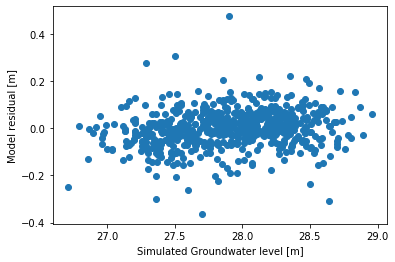

In [13]:
plt.plot(ml.observations(), ml.noise(), marker="o", linestyle=" ")
plt.xlabel("Simulated Groundwater level [m]")
plt.ylabel("Model residual [m]");

## Testing on non-equidistant residuals time series
A time series with non-equidistant time steps is created from the synthetic time series. The original time series is resampled using the indices from a observed groundwater level time series with different observation frequencies.

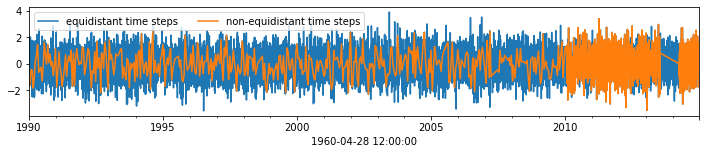

In [14]:
random_seed = np.random.RandomState(12345)
index = pd.to_datetime( np.arange(4.5 * 3650), unit="D")
noise_long = pd.Series(random_seed.normal(0, 1, len(index)), index=index).loc["1990":]

index = pd.read_csv("../data/test_index.csv", parse_dates=True, index_col=0).index.round("D").drop_duplicates()
noise_irregular = noise_long.reindex(index).dropna()

noise_long.plot(figsize=(12,2), label="equidistant time steps")
noise_irregular.plot(label="non-equidistant time steps")
plt.legend(ncol=2);

Let's run `ps.stats.diagnostics` on both of these time series and look at the differences in the outcomes:

In [15]:
ps.stats.diagnostics(noise_long, nparam=0)

/Applications/anaconda3/envs/py37_pastas/lib/python3.7/site-packages/scipy/stats/morestats.py:1676: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


,Checks,Statistic,P-value,Reject H0
Shapiroo,Normality,1.00,0.34,False
D'Agostino,Normality,3.65,0.16,False
Runs test,Autocorr.,0.12,0.90,False
Ljung-Box,Autocorr.,418.14,0.03,True
Durbin-Watson,Autocorr.,2.01,nan,False


In [16]:
ps.stats.diagnostics(noise_irregular, nparam=0)

,Checks,Statistic,P-value,Reject H0
Shapiroo,Normality,1.00,0.65,False
D'Agostino,Normality,0.26,0.88,False
Runs test,Autocorr.,2.45,0.01,True
Stoffer-Toloi,Autocorr.,380.88,0.27,False


## Diagnostic vs. hydrological checking
The diagnostic checks presented in this Notebook are only part of the checks that could be performed before using a model for different purposes. It is noted here that these checks are part of a larger ranges of checks that may be performed on a Pastas model. We also highly recommend checking the model results using hydrological insights and expert judgement. An additional notebook showing this kind of checks will be added in the future.

## Open Questions
- How well do the tests for normality and homoscedasticity work for time series with non-equidistant time steps?
- Should the weighted or unweighted residuals be used for diagnostic checking?
- Could we use the ACF for irregular timesteps in combination with Ljung-Box?
- How to determine the degrees of freedom for a test, just the parameters from the noise model, or also from the deterministic model?

## References

- Hipel, K. W., & McLeod, A. I. (1994). Time series modelling of water resources and environmental systems, [Chaper 7: Diagnostic Checking.](http://fisher.stats.uwo.ca/faculty/aim/1994Book/1994-Time-chapter%207.pdf) Elsevier.
- Ljung, G. and Box, G. (1978). [On a Measure of Lack of Fit in Time Series Models, Biometrika, 65, 297-303.](http://dx.doi.org/10.1093/biomet/65.2.297)
- Stoffer, D. S., & Toloi, C. M. (1992). [A note on the Ljung—Box—Pierce portmanteau statistic with missing data](https://www.sciencedirect.com/science/article/pii/016771529290112I). Statistics & probability letters, 13(5), 391-396.
- Durbin, J., & Watson, G. S. (1951). [Testing for serial correlation in least squares regression](https://www.jstor.org/stable/2332325). II. Biometrika, 38(1/2), 159-177.
- Wald, A., & Wolfowitz, J. (1943). [An exact test for randomness in the non-parametric case based on serial correlation](https://www.jstor.org/stable/pdf/2235925.pdf). The Annals of Mathematical Statistics, 14(4), 378-388.
- D'Agostino, R. and Pearson, E. S. (1973). [Tests for departure from normality](https://www.jstor.org/stable/2335012), Biometrika, 60, 613-622.
- Shapiro, S. S., & Wilk, M. B. (1965). [An analysis of variance test for normality (complete samples)](https://www.jstor.org/stable/pdf/2333709.pdf). Biometrika, 52(3/4), 591-611.
- Rehfeld, K., Marwan, N., Heitzig, J., & Kurths, J. (2011). [Comparison of correlation analysis techniques for irregularly sampled time series](https://npg.copernicus.org/articles/18/389/2011/). Nonlinear Processes in Geophysics, 18(3), 389-404.

## Benchmarking built-in Pastas Methods to Statsmodels methods
The following code blocks may be used to verify the output from Pastas methods to Statsmodels methods.

In [17]:
# import statsmodels.api as sm

# print("Pastas:", ps.stats.ljung_box(noise, lags=365))
# print("Statsmodels:", sm.stats.acorr_ljungbox(noise, lags=[365], return_df=False))

# acf = sm.tsa.acf(noise, unbiased=True, fft=True, nlags=365)[1:]
# q, p = sm.tsa.q_stat(acf, noise.size)
# print("Statsmodels:", q[-1], p[-1])

In [18]:
# print("Pastas:", ps.stats.durbin_watson(noise)[0].round(2))
# print("Statsmodels:", sm.stats.durbin_watson(noise).round(2))

In [19]:
# print("Pastas:", ps.stats.runs_test(noise))
# print("Statsmodels:", sm.stats.runstest_1samp(noise))